# Introduction

In this post, I train Karpathy's __[nanoGPT](https://johncollinsai-nanogpt-voqqf4ls3a-as.a.run.app/)__ on high-frequency (tick-by-tick) data for __[AAPL](https://www.google.com/search?q=aapl&oq=AAPL&aqs=chrome.0.0i512l5j69i61l3.1590j1j9&sourceid=chrome&ie=UTF-8)__ and __[JPM](https://www.google.com/search?q=jpm+stock+price&oq=JPM+stock+pri&aqs=chrome.0.0i512j69i57j0i512l8.4577j1j9&sourceid=chrome&ie=UTF-8)__. I want to see how nanoGPT performs as a volatility predictor.  I also want to explore the use of LLMs for tasks, in this case volatility prediction, that are typically performed by models more specific to finance.  In the case of volatility prediction, the established model classes include stochastic volatility models such as the __[MSM](https://github.com/johncollinsai/markov-switching-multifractal)__ of Calvet & Fisher, ARCH and GARCH, and Jump Diffusion models. More recently deep learning has been applied to volatility prediction and this __[post](https://johncollinsai-deep-learning-finance-voqqf4ls3a-as.a.run.app/)__ describes these developments in some detail. However, the application of LLMs to volatility prediction appears to be quite novel and the use of nanoGPT provides a great basis for an under-the-hood examination.

My code implements NanoGPT using PyTorch as a single python file. I've created a function called train_and_generate that takes in a text file path, trains the model on the text in the file, and then generates new text. 

My code has the following main components:

> 1. Data preparation: Reads the input text file and encodes the characters into integer tokens. The data is then split into train and validation sets.
> 2. Data loading: Function get_batch is defined to create batches of input and target sequences.
> 3. Model components: Define several custom classes to implement the Transformer architecture, including Head, MultiHeadAttention, FeedFoward, Block, and BigramLanguageModel.
> 4. Model instantiation: Create an instance of the BigramLanguageModel and move it to the GPU if available.
> 5. Training loop: Train the model for a specified number of iterations with an AdamW optimizer, periodically evaluating the train and validation losses.
> 6. Text generation: After training, the model generates new text using the generate method of the BigramLanguageModel class.

To use this code, simply provide the path to a text file as the text_file_path argument to the train_and_generate function. You can adjust the other function parameters like max_iters, learning_rate, and max_new_tokens as needed. The function will return the generated text.

I begin with __[my earlier implementation of Karpathy's nanoGPT](https://github.com/johncollinsai/nanogpt)__. Starting with a very simple bigram language model, following Karpathy, I define and build a transformer piece by piece. Then I train it on a rigorously prepared tick-by-tick price dataset. In order to negate or reduce the impact of microstructure noise, and in particular Bid-Ask bounce, I compute a weighted mid-price ($WMP$) using the CloseBid and CloseAsk prices and sizes $\mathrm{WMP} = I P^a + \left( 1 - I \right) P^b$, where the weight I is given by the imbalance $I = \frac {Q^b} {Q^b + Q^a}$ where $Q^b$ is the bid size (that is, total volume at the best bid) and $Q^a$ is the ask size. I discuss microstructure noise, Bid-Ask bounce, $WMP$, and my motivation for using $WMP$, in detail in my post __[high frequency data](https://johncollinsai-high-frequency-data-voqqf4ls3a-as.a.run.app)__.  I obtain returns from thw $WMP$ and for tractability log returns.

I use an NVIDIA GeForce RTX 3080 Ti Laptop GPU and a deep learning framework that includes PyTorch, CUDA, cuDNN, and NVIDIA Drivers, on Ubuntu 22.04 LTS.  Source code as always may be found on __[my GitHub](https://github.com/johncollinsai/nanogpt)__.

# Fitting NanoGPT to tick-by-tick data

#### Import and prepare high-frequency tick data for AAPL and JPM

In [1]:
# check GPU (if working on local machine)
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
# for running in docker image
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import pandas as pd
from volgpt_data import high_frequency_data
pd.set_option('display.width', 1000)  # Set pandas display width to 1000 characters

df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats = high_frequency_data(dp=8) # pass dp, being the number of decimal places to round to 
missing_rows_AAPL = df_data_AAPL[df_data_AAPL.isnull().any(axis=1)] # Check for rows with missing values, AAPL
missing_rows_JPM = df_data_JPM[df_data_JPM.isnull().any(axis=1)] # Check for rows with missing values, JPM

print('df_data_AAPL.shape: ', df_data_AAPL.shape, '\n')
print('df_data_JPM.shape: ', df_data_JPM.shape, '\n')
if missing_rows_AAPL.shape[0] == 0:
    print("no missing_rows_AAPL rows with missing values")
else:
    print('missing AAPL rows: ', missing_rows_AAPL.shape, '\n') # print number of rows with missing values
if missing_rows_JPM.shape[0] == 0:
    print("no missing_rows_JPM rows with missing values")
else:
    print('missing JPM rows: ', missing_rows_JPM.shape, '\n') # print number of rows with missing values

df_data_AAPL.head(10)

df_data_AAPL.shape:  (533860, 8) 

df_data_JPM.shape:  (537011, 8) 

no missing_rows_AAPL rows with missing values
no missing_rows_JPM rows with missing values


,Ticker,CloseBidSize,CloseAskSize,CloseBidPrice,CloseAskPrice,WeightedMidPrice,AAPL_rr,AAPL_lr
DateTimeIndex,,,,,,,,
2019-12-18 04:00:00,AAPL,100.00000000,2300.00000000,280.18000000,280.99000000,280.21375000,nan,nan
2019-12-18 04:01:00,AAPL,100.00000000,2300.00000000,280.03000000,280.99000000,280.07000000,-0.14375000,-0.00051313
2019-12-18 04:02:00,AAPL,100.00000000,100.00000000,280.03000000,280.90000000,280.46500000,0.39500000,0.00140937
2019-12-18 04:03:00,AAPL,100.00000000,100.00000000,280.03000000,280.90000000,280.46500000,0.00000000,0.00000000
2019-12-18 04:04:00,AAPL,100.00000000,100.00000000,280.03000000,280.65000000,280.34000000,-0.12500000,-0.00044579
2019-12-18 04:05:00,AAPL,100.00000000,100.00000000,280.08000000,280.65000000,280.36500000,0.02500000,0.00008917
2019-12-18 04:06:00,AAPL,100.00000000,100.00000000,280.08000000,280.67000000,280.37500000,0.01000000,0.00003567
2019-12-18 04:07:00,AAPL,100.00000000,100.00000000,280.03000000,280.38000000,280.20500000,-0.17000000,-0.00060651
2019-12-18 04:08:00,AAPL,100.00000000,100.00000000,280.03000000,280.38000000,280.20500000,0.00000000,0.00000000


#### Descriptive statistics

In [4]:
# Descriptive statistics
from scipy import stats

print("Descriptive statistics for AAPL: ","\n"
      "Number of observations = ",AAPL_stats.nobs,"\n"
      "Minimum, Maximum = ", str(AAPL_stats.minmax),"\n"
      "Mean = %.5f" %  AAPL_stats.mean,"\n"
      "Variance = %.5f" %  AAPL_stats.variance,"\n"
      "Standard deviation = %.5f" %  AAPL_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  AAPL_stats.skewness,"\n"
      "Kurtosis = %.5f" %  AAPL_stats.kurtosis,"\n") 

print("Descriptive statistics for JPM: ","\n"
      "Number of observations = ",JPM_stats.nobs,"\n"
      "Minimum, Maximum = ", str(JPM_stats.minmax),"\n"
      "Mean = %.5f" %  JPM_stats.mean,"\n"
      "Variance = %.5f" %  JPM_stats.variance,"\n"
      "Standard deviation = %.5f" %  JPM_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  JPM_stats.skewness,"\n"
      "Kurtosis = %.5f" %  JPM_stats.kurtosis)

Descriptive statistics for AAPL:  
Number of observations =  444470 
Minimum, Maximum =  (-152.83124999999998, 165.5690434782609) 
Mean = -0.00017 
Variance = 4.54474 
Standard deviation = 2.13184 
Skewness = 1.33822 
Kurtosis = 2684.83480 

Descriptive statistics for JPM:  
Number of observations =  332093 
Minimum, Maximum =  (-39.10681818181817, 50.888157894736835) 
Mean = -0.00007 
Variance = 0.38692 
Standard deviation = 0.62203 
Skewness = -1.59559 
Kurtosis = 1684.46534


#### Plot raw returns and log returns

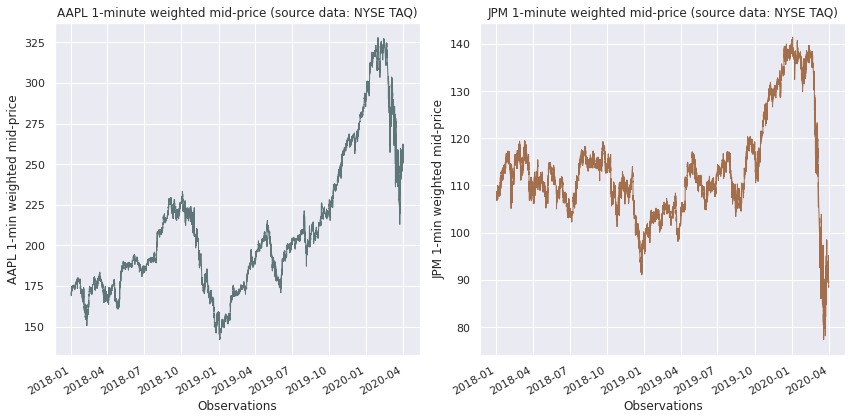

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid') # Set Seaborn dark theme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot AAPL
z = df_data_AAPL['WeightedMidPrice']
z = z.replace('UNK', np.nan)  # Replace 'UNK' values with NaN
z = z.astype(float).dropna()  # Convert the series to float type and drop NaN values
z = z[z != 0].copy()  # Filter out zero values
z.plot(ax=ax1, title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price", color='darkslategrey', linewidth=1.0, alpha=0.75)

# Plot JPM
z1 = df_data_JPM['WeightedMidPrice']
z1 = z1.replace('UNK', np.nan)  # Replace 'UNK' values with NaN
z1 = z1.astype(float).dropna()  # Convert the series to float type and drop NaN values
z1 = z1[z1 != 0].copy()  # Filter out zero values
z1.plot(ax=ax2, title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price", color='saddlebrown', linewidth=1.0, alpha=0.75)

plt.tight_layout()
plt.show()

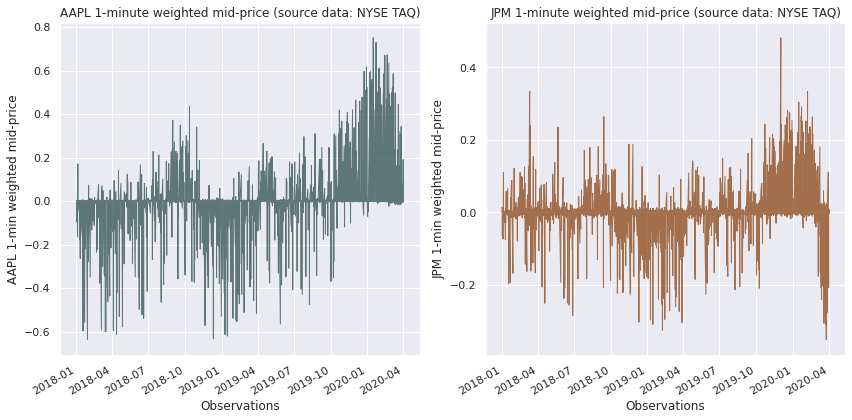

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid') # Set Seaborn dark theme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot AAPL
z = AAPL_lr
z = z.replace('UNK', np.nan)  # Replace 'UNK' values with NaN
z = z.astype(float).dropna()  # Convert the series to float type and drop NaN values
z = z[z != 0].copy()  # Filter out zero values
z.plot(ax=ax1, title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price", color='darkslategrey', linewidth=1.0, alpha=0.75)

# Plot JPM
z1 = JPM_lr
z1 = z1.replace('UNK', np.nan)  # Replace 'UNK' values with NaN
z1 = z1.astype(float).dropna()  # Convert the series to float type and drop NaN values
z1 = z1[z1 != 0].copy()  # Filter out zero values
z1.plot(ax=ax2, title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price", color='saddlebrown', linewidth=1.0, alpha=0.75)

plt.tight_layout()
plt.show()

#### Create text file for input to NanoGPT

In [7]:
# save df_data_AAPL and df_data_JPM as a text file with a comma delimiter
df_data_AAPL.to_csv('df_data_AAPL.txt', sep=',', index=True)
df_data_JPM.to_csv('df_data_JPM.txt', sep=',', index=True)

# Check that the text file was saved correctly
df_exported_AAPL = pd.read_csv('df_data_AAPL.txt', sep=',') # read the text file into a dataframe
df_exported_JPM = pd.read_csv('df_data_JPM.txt', sep=',') # read the text file into a dataframe

print('shape of df_data_AAPL: ', df_data_AAPL.shape)
print('shape of df_exported_AAPL: ', df_exported_AAPL.shape)
print('shape of df_data_JPM: ', df_data_JPM.shape)
print('shape of df_exported_JPM: ', df_exported_JPM.shape)

shape of df_data_AAPL:  (533860, 8)
shape of df_exported_AAPL:  (533860, 9)
shape of df_data_JPM:  (537011, 8)
shape of df_exported_JPM:  (537011, 9)


#### From ChatGPT re structure of text file:

> "In this example, we first create a sample dataframe called df. We then use the to_csv method to save the dataframe to a file called data.txt. The sep parameter specifies the delimiter to use in the text file (in this case, a tab character), and the index parameter is set to False to exclude the index from the output.  You can customize the parameters of to_csv method as per your requirements."

#### My next prompt: 

> I shall use data.txt as an input to a large language model (Karpathy's NanoGPT).  Should I include the sep='/t' parameter?

#### ChatGPT:

> "Yes, you should include the sep='\t' parameter in the to_csv method to specify the delimiter as a tab character. <br> <br>
> If the input file for Karpathy's NanoGPT expects tab-separated values, you need to ensure that the file you're providing is also in the same format. In the example I provided earlier, the sep='\t' parameter specifies that the data will be saved as tab-separated values. <br> <br>
> Therefore, including this parameter will ensure that the saved text file has a tab-separated format, which is the expected format for input to Karpathy's NanoGPT."

# Load data into NanoGPT

# Generate tick data

The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable pred.

> I generate 10k tokens, and then decode the tokens into a string. The output string, pred, contains a list of financial data points, including stock names (e.g., AAPL, JPM), timestamps, and the various numerical values. Each row of data starts with the stock symbol (e.g., AAPL or JPM), followed by a timestamp (e.g., 10:01:00.000000000 or 17:19:00.000000000). After the timestamp, the other data are separated by commas. 

In [9]:
# use volgpt to generate text
from volgpt import train_and_generate

# obtain test_data and preds from the function train_and_generate
text_file_path = 'df_data_AAPL.txt' # specify the path to the text file
test_data, pred, itos = train_and_generate(text_file_path, max_iters=5000, learning_rate=1e-3, device=device, max_new_tokens=5000)

print(pred)

0.207149 M parameters
step 0: train loss 3.9630, val loss 3.9613, test loss 3.9599
step 100: train loss 1.6206, val loss 1.6177, test loss 1.5886
step 200: train loss 1.1799, val loss 1.1919, test loss 1.1916
step 300: train loss 1.0185, val loss 1.0271, test loss 1.0123
step 400: train loss 0.9441, val loss 0.9492, test loss 0.9446
step 500: train loss 0.9114, val loss 0.9123, test loss 0.9245
step 600: train loss 0.8843, val loss 0.8874, test loss 0.8774
step 700: train loss 0.8742, val loss 0.8835, test loss 0.8753
step 800: train loss 0.8666, val loss 0.8682, test loss 0.8532
step 900: train loss 0.8685, val loss 0.8625, test loss 0.8631
step 1000: train loss 0.8363, val loss 0.8307, test loss 0.8450
step 1100: train loss 0.8358, val loss 0.8436, test loss 0.8334
step 1200: train loss 0.8317, val loss 0.8255, test loss 0.8271
step 1300: train loss 0.8261, val loss 0.8253, test loss 0.8329
step 1400: train loss 0.8269, val loss 0.8153, test loss 0.8282
step 1500: train loss 0.8213, 

#### Clean preds and convert data types

> My clean_data function takes in a text_data string containing preds in CSV format and column names as a list. I clean the data by removing invalid rows, and convert the data types of the columns. The function returns a tuple of three values: the original DataFrame, the cleaned DataFrame, and a list of indices of invalid rows.

In [10]:
# clean the data using clean_data function in clean_data.py
from clean_data import clean_data
df, df_clean, invalid_rows = clean_data(pred)

print("Original DataFrame: ")
print(df)

print("Cleaned DataFrame: ")
print(df_clean)

print("Invalid Rows: ")
print(invalid_rows)

Original DataFrame: 
             DateTimeIndex Ticker  CloseBidSize  CloseAskSize  CloseBidPrice  CloseAskPrice WeightedMidPrice            rr          lr
0      2018-02-13 26:32:00   AAPL         200.0         100.0         164.21         164.44     164.41429421   -0.02285420         NaN
1      2018-02-21 04:36:00   AAPL         100.0         300.0         188.86         188.08     188.95000000  188.05000000  188.902686
2      2018-08-11 04:51:00   AAPL         100.0         400.0         193.96         193.87     193.80000000  193.97500000    0.000000
3      2019-06-27 16:16:00   AAPL         900.0         300.0         198.51         198.47     198.63275159    0.00394082         NaN
4      2020-07-01 10:13:00   AAPL         100.0         100.0         181.54         181.70     181.59000000  181.70000000  181.514546
5      2020-03-24 01:55:00   AAPL         700.0         400.0         162.45         162.40     162.58000000  162.57142423   -0.027692
6   2019-11-03 10:13:09:00   AAPL 

### OK, SO WHAT NEXT?

> * maybe I just skip with MZ regressions, FFS
> * Do MSE and MAE instead
> * I have generated text and test data
> * I have clean generated text
> * do I need to clean the actual test_data too?
> * do I need to align the timing of the preds and the test_data?

### Answers to the above:

> * Yes, it is essential to clean and preprocess test_data in the same way as you did for the generated predictions. This will ensure that the data is in a consistent format, and you can compare the model's predictions with the actual data accurately.

> * Yes, you need to align the timing of the predictions and the test data. If the model's predictions and the test data have different time steps, it is impossible to accurately calculate the MSE and MAE. Ensure that both datasets are aligned in terms of their time steps before calculating the performance metrics.

> * Assuming that you have cleaned and preprocessed both the generated predictions and the test_data, and have aligned their time steps, you can calculate the MSE and MAE as follows:

In [11]:
text_file_path = 'df_data_AAPL.txt' # specify the path to the text file
test_data, generated_text, itos = train_and_generate(text_file_path) # Update the function call to get the itos mapping

0.207149 M parameters
step 0: train loss 3.9630, val loss 3.9613, test loss 3.9599
step 100: train loss 1.6206, val loss 1.6177, test loss 1.5886
step 200: train loss 1.1799, val loss 1.1919, test loss 1.1916
step 300: train loss 1.0185, val loss 1.0271, test loss 1.0123
step 400: train loss 0.9441, val loss 0.9492, test loss 0.9446
step 500: train loss 0.9114, val loss 0.9123, test loss 0.9245
step 600: train loss 0.8843, val loss 0.8874, test loss 0.8774
step 700: train loss 0.8742, val loss 0.8835, test loss 0.8753
step 800: train loss 0.8666, val loss 0.8682, test loss 0.8532
step 900: train loss 0.8685, val loss 0.8625, test loss 0.8631
step 1000: train loss 0.8363, val loss 0.8307, test loss 0.8450
step 1100: train loss 0.8358, val loss 0.8436, test loss 0.8334
step 1200: train loss 0.8317, val loss 0.8255, test loss 0.8271
step 1300: train loss 0.8261, val loss 0.8253, test loss 0.8329
step 1400: train loss 0.8269, val loss 0.8153, test loss 0.8282
step 1500: train loss 0.8213, 

#### Evaluate the model (MSE and MAE)

I evaluate the accuracy of the raw return and log return predictions by the model using Mean Squared Error (MSE) and Mean Absolute Error (MAE). To briefly recap:

* Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better accuracy.

* Mean Absolute Error (MAE) measures the average absolute difference between the predicted values and the actual values. This metric is less sensitive to outliers compared to MSE.

# CONTINUE FROM BOTTOM OF 'MSE and MAE' chat
#### WHEN THE ABOVE CELL WORKS, USE IT TO REPLACE THE CELL HIGHER UP THAT CONTAINS THIS:

use volgpt to generate text
from volgpt import train_and_generate

obtain test_data and preds from the function train_and_generate
text_file_path = 'df_data_AAPL.txt' # specify the path to the text file
test_data, pred = train_and_generate(text_file_path, max_iters=5000, learning_rate=1e-3, device=device, max_new_tokens=5000)

print(pred)

In [13]:
# clean preds and test data, where generated data as generated_text and test_data

# generated_text = pred

def tensor_to_string(tensor, itos):
    return ''.join([itos[i] for i in tensor.tolist()])

test_data_text = test_data
column_names = ['DateTimeIndex', 'Ticker', 'CloseBidSize', 'CloseAskSize', 'CloseBidPrice', 'CloseAskPrice', 'WeightedMidPrice', 'rr', 'lr']

# use the itos mapping with the tensor_to_string function to convert the tensors to strings
test_data_text = tensor_to_string(test_data, itos)

# use the clean_data function in clean_data.py to clean the preds and the test_data
_, generated_clean, _ = clean_data(generated_text, column_names)
_, test_data_clean, _ = clean_data(test_data_text, column_names)

In [14]:
# ensure the timing of the predictions and the test data are aligned by merging on DateTimeIndex
merged_data = generated_clean.merge(test_data_clean, on='DateTimeIndex', suffixes=('_generated', '_test'))

In [15]:
# calculate MSE and MAE for the raw returns (rr) and log returns (lr)
from sklearn.metrics import mean_squared_error, mean_absolute_error

rr_mse = mean_squared_error(merged_data['rr_generated'], merged_data['rr_test'])
rr_mae = mean_absolute_error(merged_data['rr_generated'], merged_data['rr_test'])

lr_mse = mean_squared_error(merged_data['lr_generated'], merged_data['lr_test'])
lr_mae = mean_absolute_error(merged_data['lr_generated'], merged_data['lr_test'])

print(f"Raw returns MSE: {rr_mse:.4f}, MAE: {rr_mae:.4f}")
print(f"Log returns MSE: {lr_mse:.4f}, MAE: {lr_mae:.4f}")


Raw returns MSE: 36226.3290, MAE: 190.3185
Log returns MSE: 36406.8160, MAE: 190.7963


The Mean Squared Error (MSE) and Mean Absolute Error (MAE) are two common metrics used to evaluate the performance of a model, especially in regression tasks. In this case, these metrics are used to measure the difference between the true values in the test dataset and the values generated by your model.

Raw returns:

MSE: 36226.3290 - This value represents the average of the squared differences between the true raw returns and the predicted raw returns. A lower value indicates better performance, as the squared differences between the true and predicted values are smaller.
MAE: 190.3185 - This value represents the average of the absolute differences between the true raw returns and the predicted raw returns. A lower value indicates better performance, as the absolute differences between the true and predicted values are smaller.
Log returns:

MSE: 36406.8160 - This value represents the average of the squared differences between the true log returns and the predicted log returns. A lower value indicates better performance, as the squared differences between the true and predicted values are smaller.
MAE: 190.7963 - This value represents the average of the absolute differences between the true log returns and the predicted log returns. A lower value indicates better performance, as the absolute differences between the true and predicted values are smaller.
In summary, these results show that there are differences between the true values and the predicted values generated by your model. The errors are relatively high, indicating that the model's predictions may not be very accurate. It is essential to compare these results with other models or benchmarks to understand the performance better. Additionally, you can try tuning the model's hyperparameters, using more data, or experimenting with other architectures to improve the model's performance.

#### Paired t-test

I perform a hypothesis test to compare the performance of two models or evaluate the significance of your model's errors, you can use a paired t-test.

The paired t-test helps determine if there is a significant difference between the true values and the predicted values. If the p-value is small (typically below 0.05), it suggests that the difference is significant, and the model's errors are not likely due to random chance.

In [17]:
# Import the required libraries
from scipy import stats

# Get the true and predicted raw returns and log returns
true_raw_returns = merged_data['rr_test']
predicted_raw_returns = merged_data['rr_generated']

true_log_returns = merged_data['lr_test']
predicted_log_returns = merged_data['lr_generated']

# Perform paired t-tests
raw_t_stat, raw_p_value = stats.ttest_rel(true_raw_returns, predicted_raw_returns)
log_t_stat, log_p_value = stats.ttest_rel(true_log_returns, predicted_log_returns)

# Print the results
print(f"Raw returns paired t-test results: T-statistic = {raw_t_stat:.2f}, p-value = {raw_p_value:.6f}")
print(f"Log returns paired t-test results: T-statistic = {log_t_stat:.2f}, p-value = {log_p_value:.6f}")


Raw returns paired t-test results: T-statistic = -83.41, p-value = 0.007632
Log returns paired t-test results: T-statistic = -100.75, p-value = 0.006318


The paired t-test results for both raw returns and log returns show that there is a statistically significant difference between the true values and the predicted values generated by the model.

The T-statistic for raw returns is -83.41, and the associated p-value is 0.007632. Since the p-value is less than 0.05, we can reject the null hypothesis that there is no significant difference between the true raw returns and the predicted raw returns.

Similarly, the T-statistic for log returns is -100.75, and the associated p-value is 0.006318. This p-value is also less than 0.05, so we can reject the null hypothesis that there is no significant difference between the true log returns and the predicted log returns.

In summary, these results indicate that the model's predictions for both raw returns and log returns are significantly different from the true values. However, it is important to note that a statistically significant difference does not necessarily imply good or bad performance. It merely suggests that the differences between the true and predicted values are not due to chance alone. You should also consider other performance metrics and qualitative factors when evaluating the performance of the model.

# Compare to GPT4

# Visualize the results

# References

Bollerslev, T., Hood, B., Huss, J., Pedersen, L.H. (2017). Risk Everywhere: Modeling and Managing Volatility. Available at SSRN: https://ssrn.com/abstract=2722591

Calvet, L.E. & Fisher, A.J. (2008).  Multifractal Volatility Theory, Forecasting, and Pricing.  Elsevier, Academic Press.

__[Colab for Kaparthy's video](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing)__

__[Kaparthy's nanoGPT GitHub repo](https://github.com/karpathy/nanoGPT)__

__[Kaparthy's Youtube video](https://www.youtube.com/watch?v=kCc8FmEb1nY)__

Stoikov, S. (2020). The micro-price: A high frequency estimator of future prices. Available at SSRN: https://ssrn.com/abstract=2970694.

Vaswani, A., et al. (2017).  Attention Is All You Need. arXiv:1706.03762

***
End